In [11]:
# -*- coding:utf-8 -*-
# Author:凌逆战 | Never
# Date: 2023/6/9
"""
Orka 窗函数: 无论窗长设置为多少，总延迟仅为帧移的两倍
32kHz采样率
帧移 2ms
窗长 16ms
总延迟 4ms
N2-R=384; N2+R=512

R = hop size
0 < N1 < N2-R
"""
import numpy as np
import librosa
import matplotlib.pyplot as plt


In [12]:
frame_len = 32
window_len = NFFT = 512

# Orka 窗

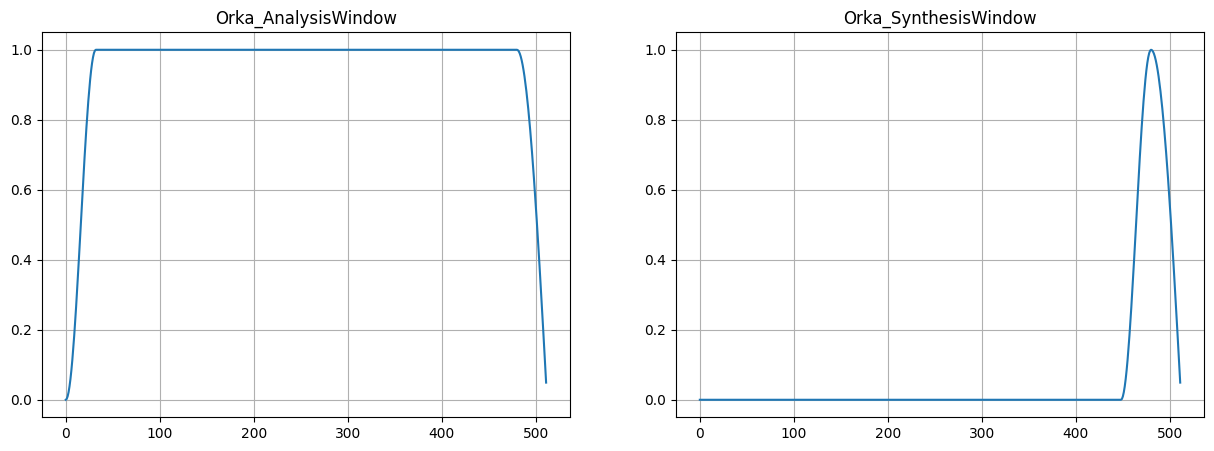

In [13]:
def Orka_forward_window(N1=64, N2=448, hop_size=64, NFFT=512):
    analysisWindow = np.zeros(NFFT)
    for n in range(NFFT):
        if n < N1:
            analysisWindow[n] = np.sin(n * np.pi / (2 * N1)) ** 2
        elif N1 <= n <= N2:
            analysisWindow[n] = 1
        elif N2 < n <= N2 + hop_size:
            analysisWindow[n] = np.sin(np.pi * (N2 + hop_size - n) / (2 * hop_size))

    return analysisWindow


def Orka_backward_window(N1=64, N2=448, hop_size=64, NFFT=512):
    synthesisWindow = np.zeros(NFFT)
    for n in range(NFFT):
        if n < N2 - hop_size:
            synthesisWindow[n] = 0
        elif N2 - hop_size <= n <= N2:
            synthesisWindow[n] = np.cos(np.pi * (n - N2) / (2 * hop_size)) ** 2
        elif N2 < n <= N2 + hop_size:
            synthesisWindow[n] = np.sin(np.pi * (N2 + hop_size - n) / (2 * hop_size))
    return synthesisWindow


N1 = frame_len
N2 = NFFT - frame_len
Orka_forward = Orka_forward_window(N1=N1, N2=N2, hop_size=frame_len, NFFT=NFFT)
Orka_backward = Orka_backward_window(N1=N1, N2=N2, hop_size=frame_len, NFFT=NFFT)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Orka_AnalysisWindow")
plt.grid()
plt.plot(Orka_forward)

plt.subplot(1, 2, 2)
plt.title("Orka_SynthesisWindow")
plt.grid()
plt.plot(Orka_backward)
plt.show()

# Tukey 窗

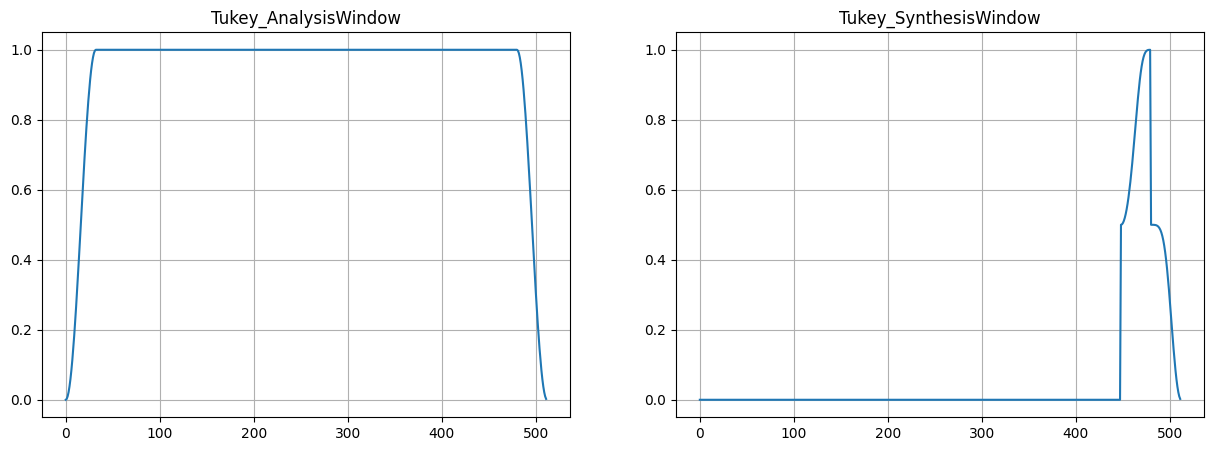

In [14]:
def TukeyAW(n, N, alpha):
    # assert n >= 0
    if n < alpha * N:
        return 0.5 * (1 - np.cos(np.pi * n / (alpha * N)))
    elif n <= N - alpha * N:
        return 1
    elif n <= N:
        return 0.5 * (1 - np.cos(np.pi * (N - n) / (alpha * N)))


def getTukeyAnalysisWindow(filter_length, alpha):
    analysisWindow = np.zeros(filter_length)
    for i in range(filter_length):
        analysisWindow[i] = TukeyAW(i, filter_length, alpha)
    return analysisWindow


def getTukeySynthesisWindow(N, A, B, alpha):
    synthesisWindow = np.zeros(A)
    for i in range(A):
        x = N - A + i
        numerator = TukeyAW(x, N, alpha)
        denonminator = 0
        for k in range(int(A / B)):
            y = N - A + i % B + k * B
            denonminator += TukeyAW(y, N, alpha) ** 2
        synthesisWindow[i] = numerator / denonminator

    synthesisWindow = np.pad(synthesisWindow, (N - A, 0), 'constant', constant_values=0)
    return synthesisWindow


alpha = 0.0625
Tukey_AnalysisWindow = getTukeyAnalysisWindow(NFFT, alpha=alpha)
Tukey_SynthesisWindow = getTukeySynthesisWindow(NFFT, A=frame_len*2, B=frame_len, alpha=alpha)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Tukey_AnalysisWindow")
plt.grid()
plt.plot(Tukey_AnalysisWindow)

plt.subplot(1, 2, 2)
plt.title("Tukey_SynthesisWindow")
plt.grid()
plt.plot(Tukey_SynthesisWindow)
plt.show()

# Asqrt hann 窗

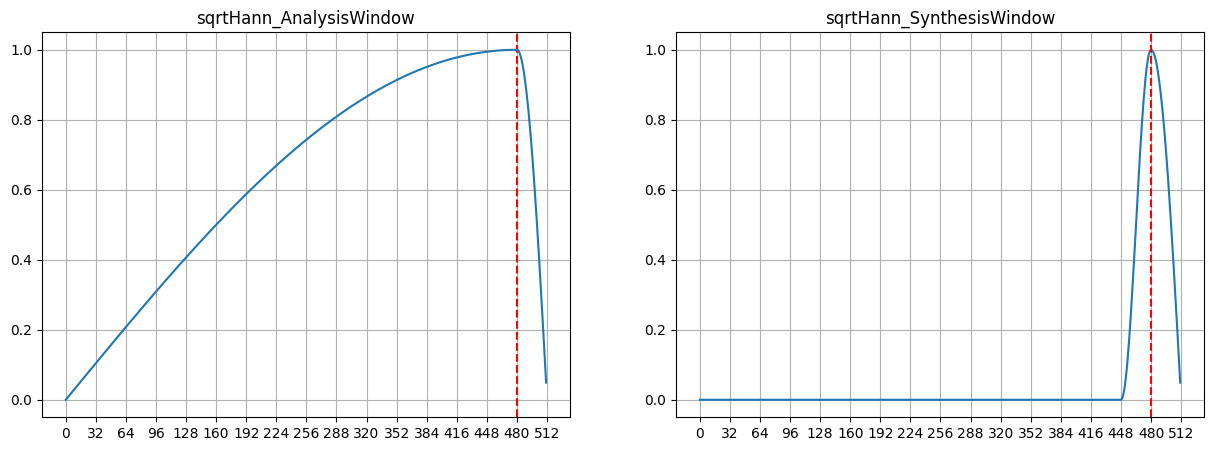

In [15]:
def getAsqrtAnalysisWindow(N, M, d):
    # filter_length, hop_length, d
    risingSqrtHann = np.sqrt(np.hanning(2 * (N - M - d) + 1)[:(N - M - d)])
    fallingSqrtHann = np.sqrt(np.hanning(2 * M + 1)[:2 * M])  # 下降

    window = np.zeros(N)
    window[:d] = 0
    window[d:N - M] = risingSqrtHann[:N - M - d]
    window[N - M:] = fallingSqrtHann[-M:]

    return window


def getAsqrtSynthesisWindow(N, M, d):
    risingSqrtHannAnalysis = np.sqrt(np.hanning(2 * (N - M - d) + 1)[:(N - M - d)])
    fallingSqrtHann = np.sqrt(np.hanning(2 * M + 1)[:2 * M])
    risingNoramlizedHann = np.hanning(2 * M + 1)[:M] / risingSqrtHannAnalysis[N - 2 * M - d:N - M - d]

    window = np.zeros(N)
    window[:-2 * M] = 0
    window[-2 * M:-M] = risingNoramlizedHann
    window[-M:] = fallingSqrtHann[-M:]

    return window


N = NFFT
M = frame_len  # int(frame_len * 4)
d = 0
sqrtHann_AnalysisWindow = getAsqrtAnalysisWindow(N, M, d=d)
sqrtHann_SynthesisWindow = getAsqrtSynthesisWindow(N, M, d=d)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("sqrtHann_AnalysisWindow")
plt.xticks(np.arange(0, window_len + frame_len, frame_len))
# 在刻度M和2M处画一条竖向
plt.axvline(x=N - M, color='r', linestyle="--")
plt.grid()
plt.plot(sqrtHann_AnalysisWindow)

plt.subplot(1, 2, 2)
plt.title("sqrtHann_SynthesisWindow")
plt.plot(sqrtHann_SynthesisWindow)
plt.xticks(np.arange(0, window_len + frame_len, frame_len))
plt.axvline(x=N - M, color='r', linestyle="--")
plt.grid()
plt.show()


## 重叠相加

wav_pad.shape (1472,)
帧数 31
analyze_result 1472


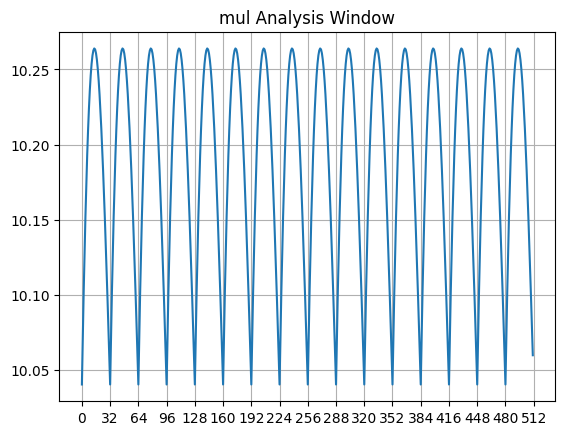

In [16]:
# 对值为1的信号进行分帧和重叠相加
signal = np.ones(window_len)
# 如果不补零的话，前半帧和后半帧 会因为加窗而无法恢复
wav_pad = np.pad(signal, (NFFT - frame_len, NFFT - frame_len), mode="constant")  # center=True
print("wav_pad.shape", wav_pad.shape)
# librosa有专门的分帧函数
frame_array = librosa.util.frame(wav_pad, frame_length=window_len, hop_length=frame_len)  # (帧长,帧数)
window_len, frame_num = frame_array.shape
print("帧数", frame_num)
# 加窗
win_array = np.zeros_like(frame_array)
analyze_result = np.zeros(window_len + frame_len * (frame_num - 1))
print("analyze_result", len(analyze_result))
for frame_index in range(frame_num):
    # win_array[:, frame_index] = frame_array[:, frame_index] * Orka_forward  # 乘以分析窗
    win_array[:, frame_index] = frame_array[:, frame_index] * sqrtHann_AnalysisWindow  # 乘以分析窗
    analyze_result[frame_index * frame_len: frame_index * frame_len + window_len] += win_array[:, frame_index]

plt.title('mul Analysis Window')
plt.plot(analyze_result[(NFFT - frame_len): -(NFFT - frame_len)])
plt.xticks(np.arange(0, window_len + frame_len, frame_len))
plt.grid()
plt.show()

In [17]:
def overlap_add(win_array, sys_hop_size):
    wav_sys = np.zeros(window_len + sys_hop_size * (frame_num - 1))
    for frame_index in range(frame_num):
        # ytmp = win_array[:, frame_index] * Orka_backward  # 乘以合成窗
        ytmp = win_array[:, frame_index] * sqrtHann_SynthesisWindow  # 乘以合成窗
        # plt.subplot(1, 3, 1)
        # plt.plot(win_array[:, frame_index])
        # plt.subplot(1, 3, 2)
        # plt.plot(Orka_backward)
        # plt.subplot(1, 3, 3)
        # plt.plot(ytmp)  # 后面有128个点，64的帧移。
        # # 打印返回Orka_backward大于0的值的索引
        # print(np.where(Orka_backward > 0))
        #
        # plt.show()
        # break
        wav_sys[frame_index * sys_hop_size: (frame_index * sys_hop_size + window_len)] += ytmp
        plt.figure(figsize=(20, 5))
        plt.plot(wav_sys[window_len - sys_hop_size: -(window_len - sys_hop_size)])
        plt.xticks(np.arange(0, window_len * 2 - sys_hop_size, sys_hop_size))
        plt.grid()
        plt.show()
    wav_sys = wav_sys[(NFFT - sys_hop_size): -(NFFT - sys_hop_size)]
    print("wav_sys.shape", wav_sys.shape)
    return wav_sys

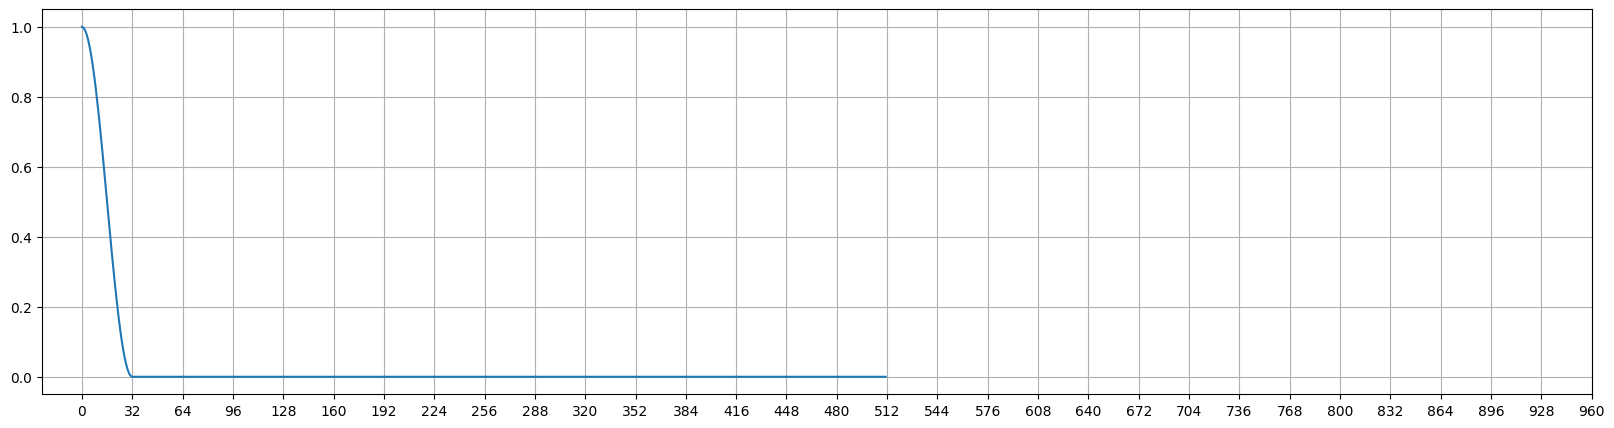

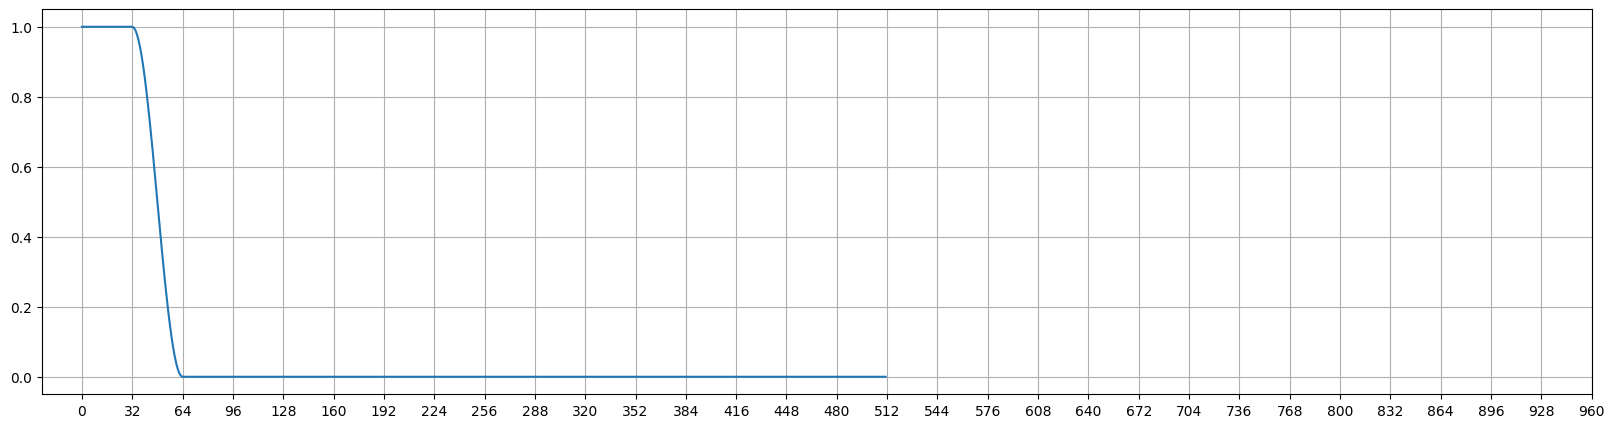

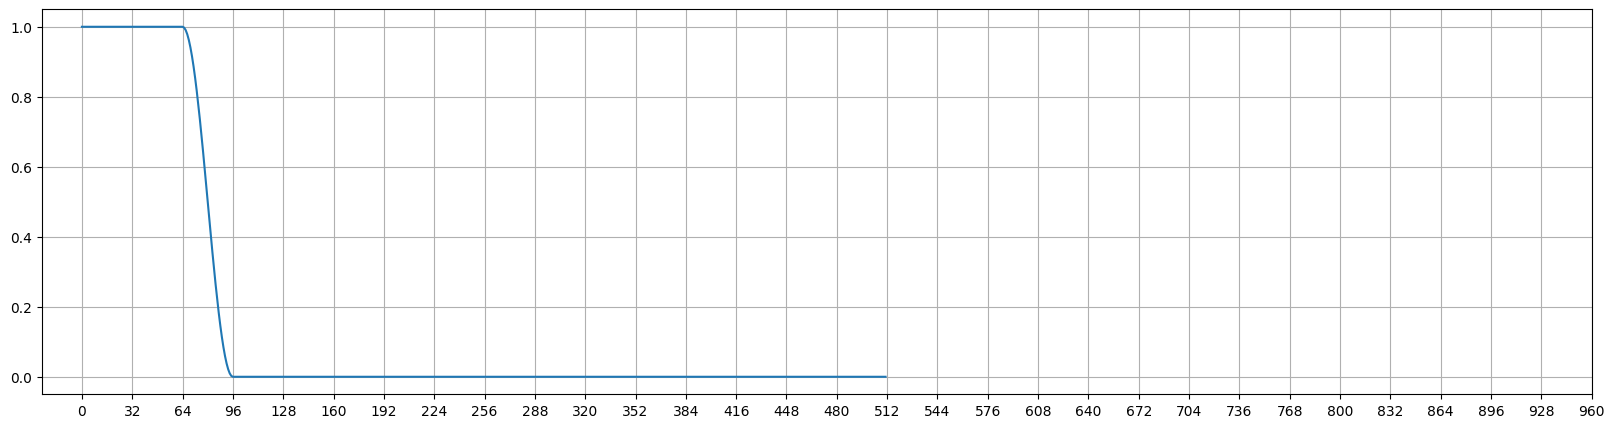

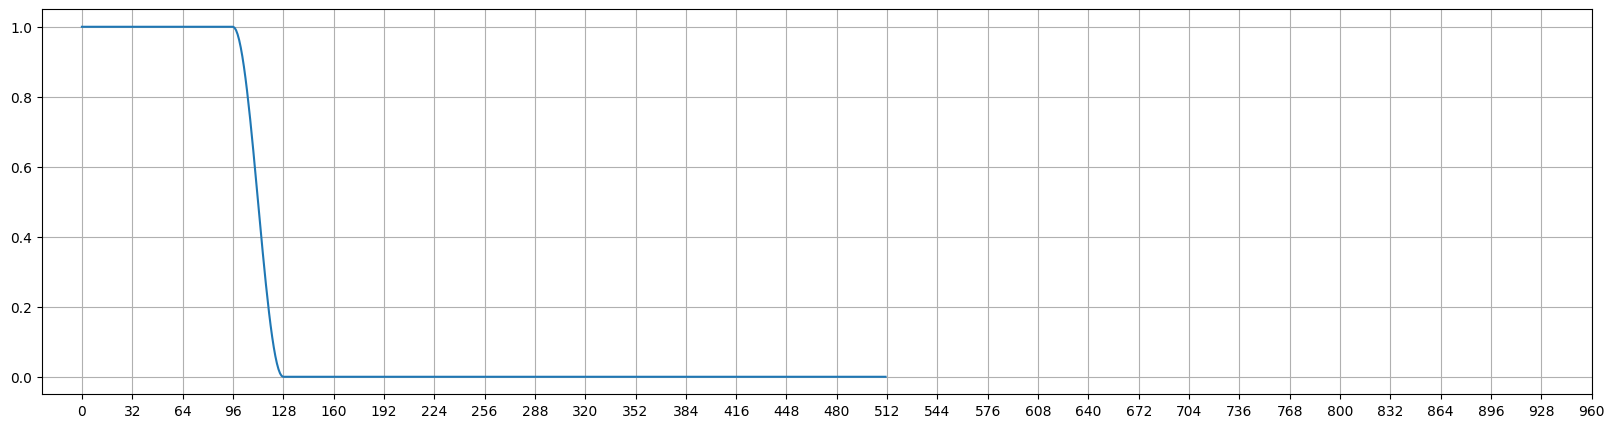

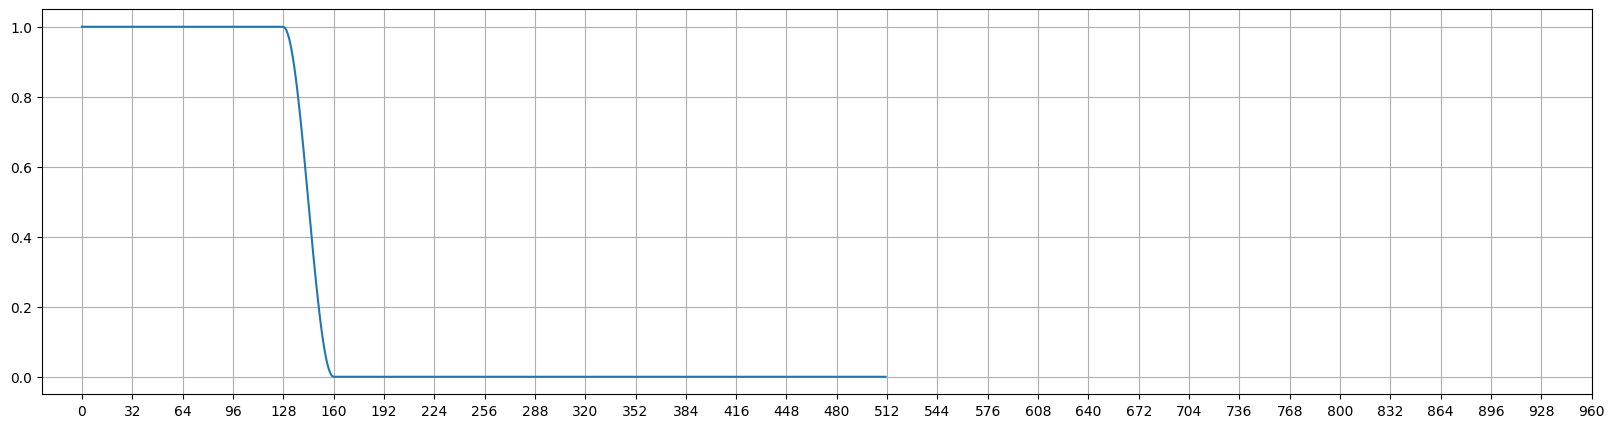

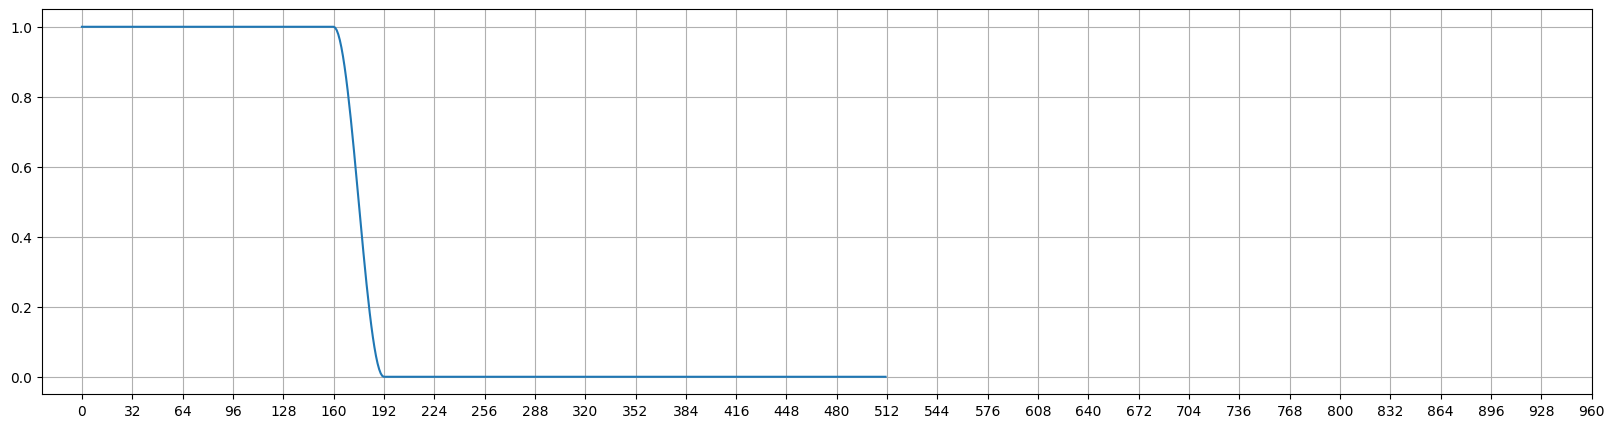

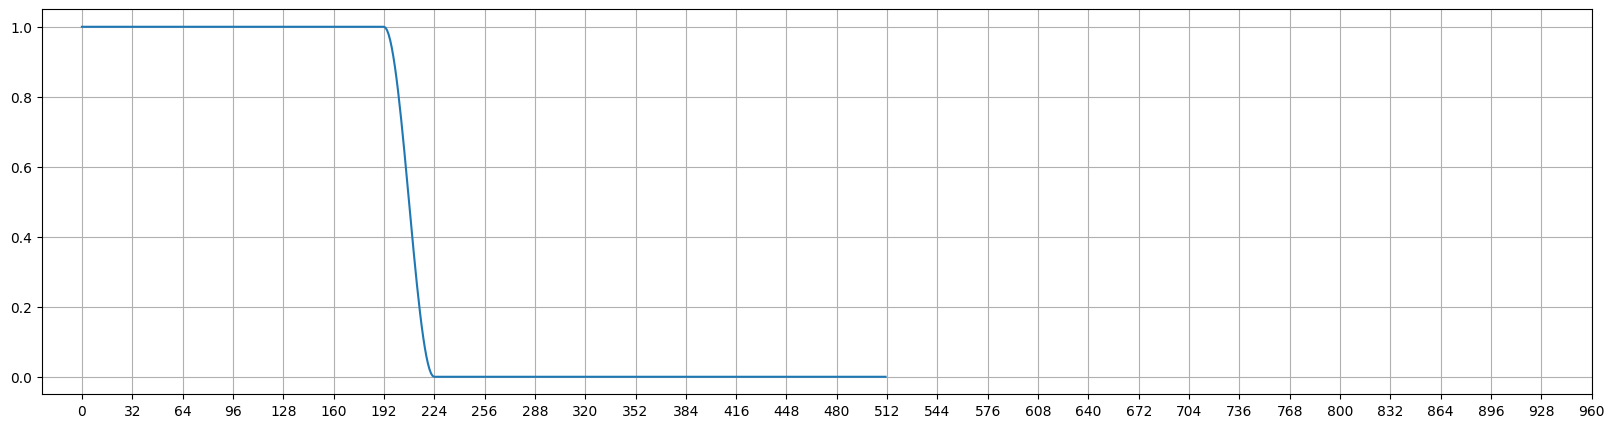

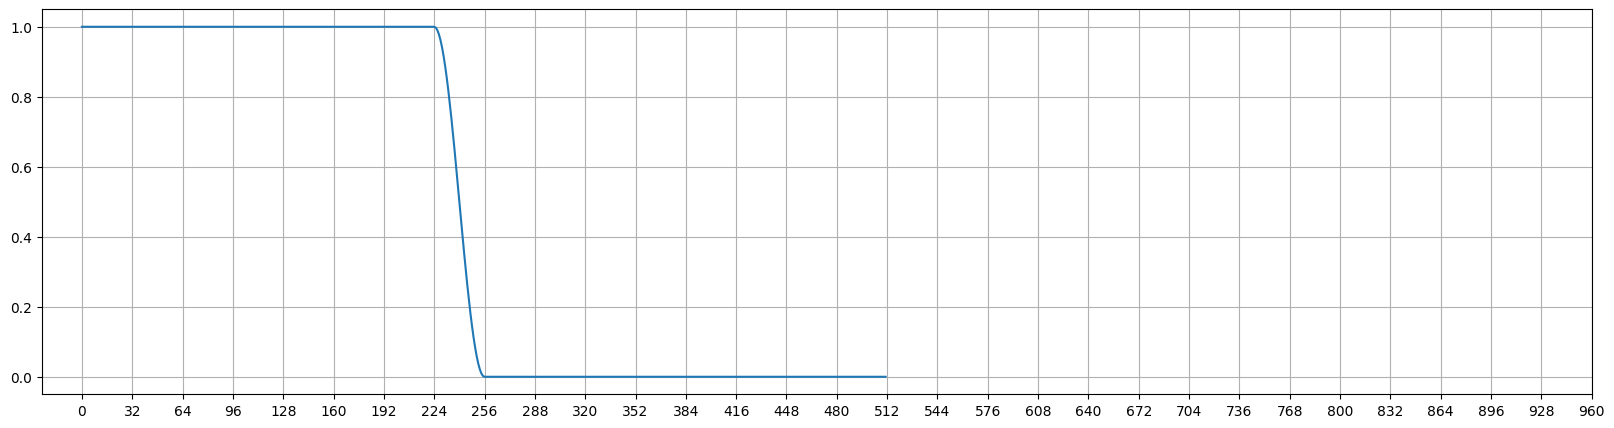

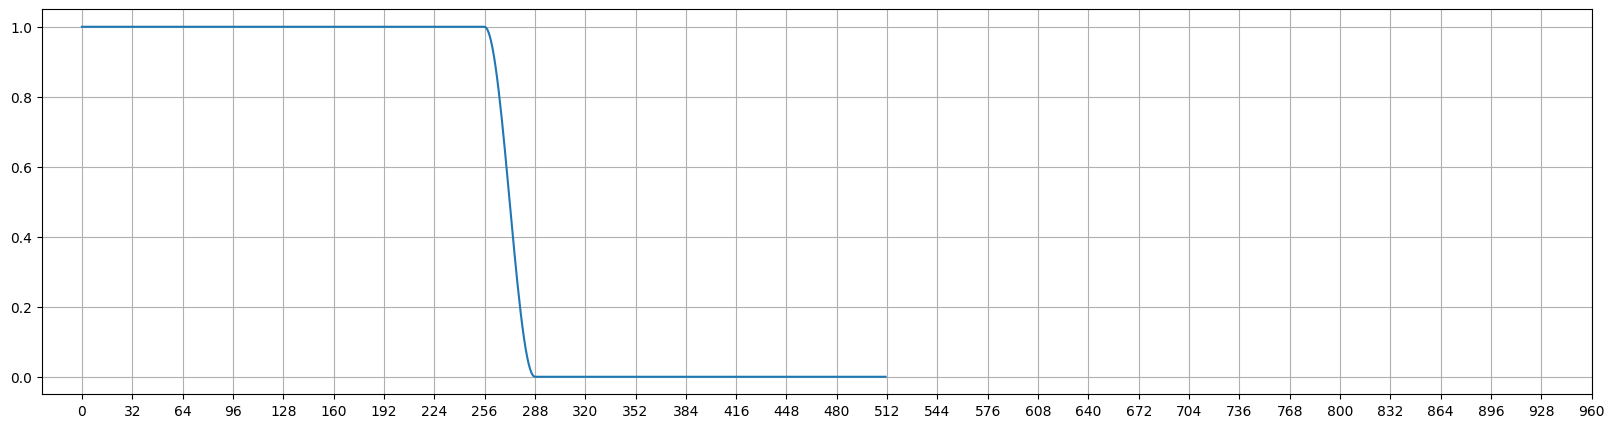

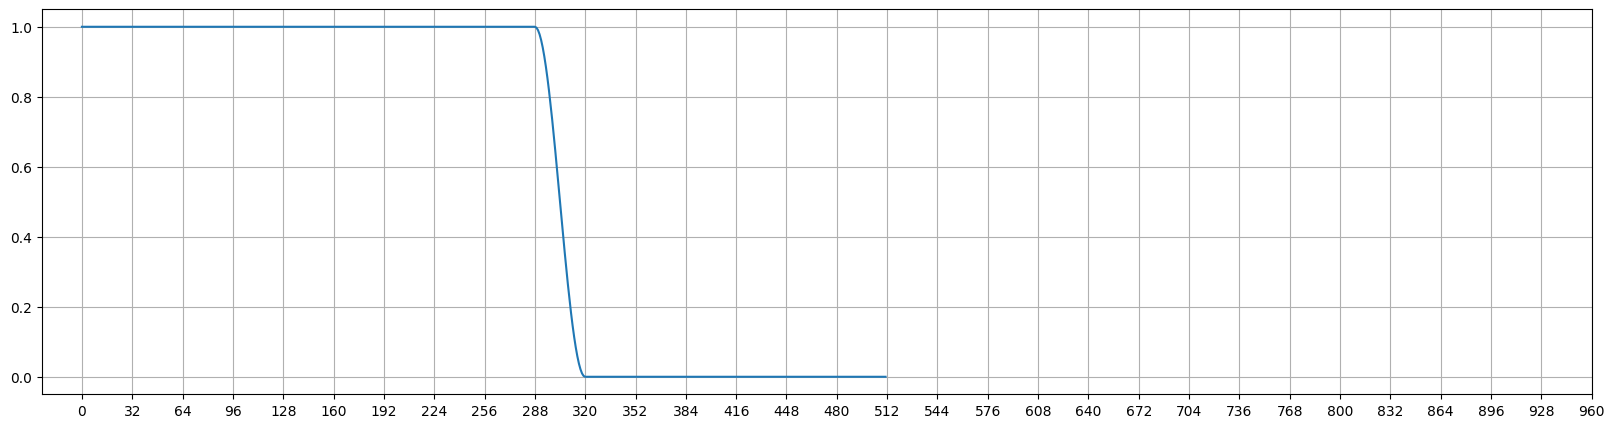

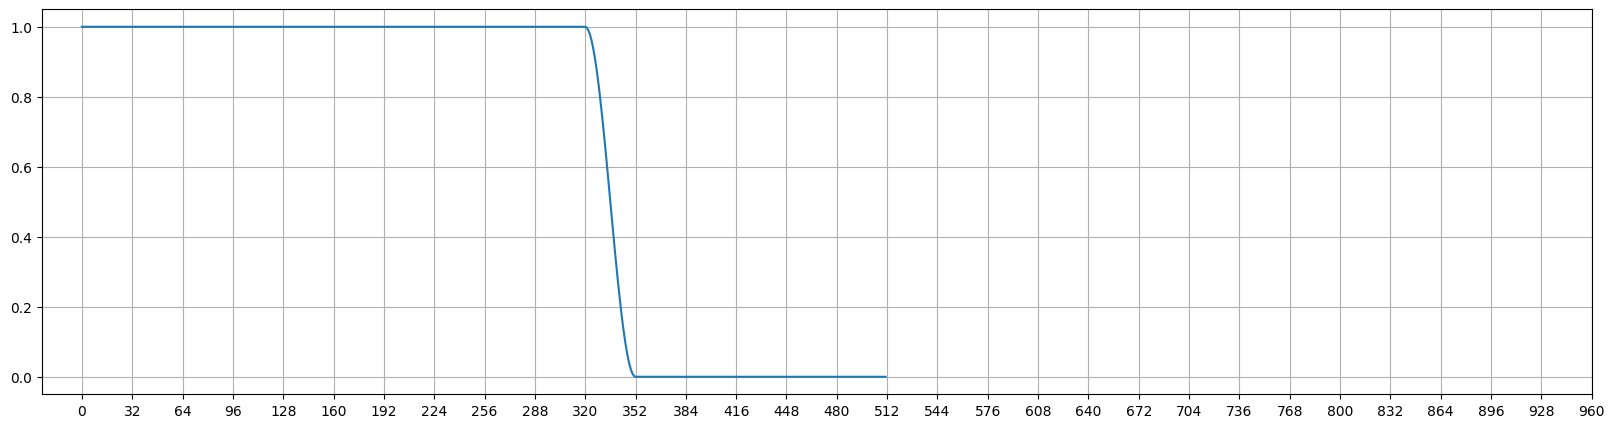

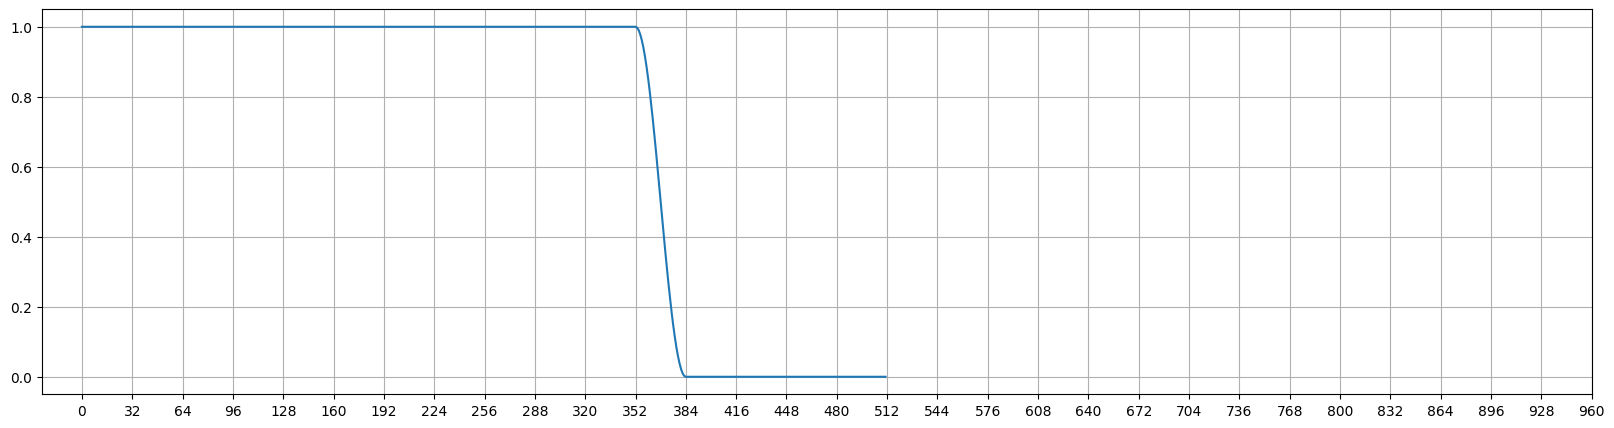

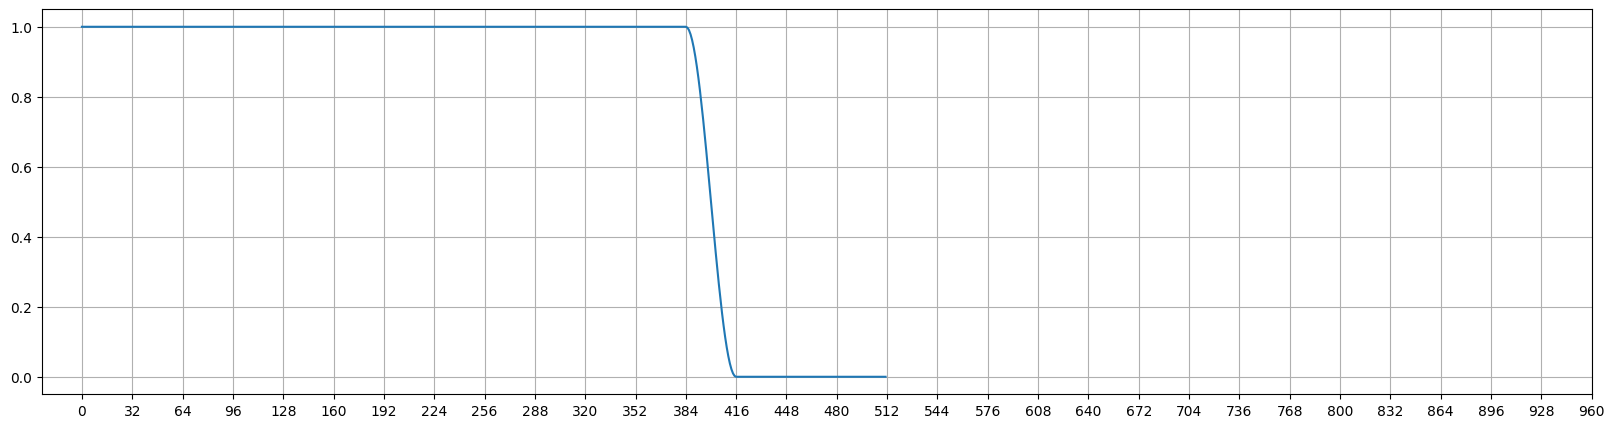

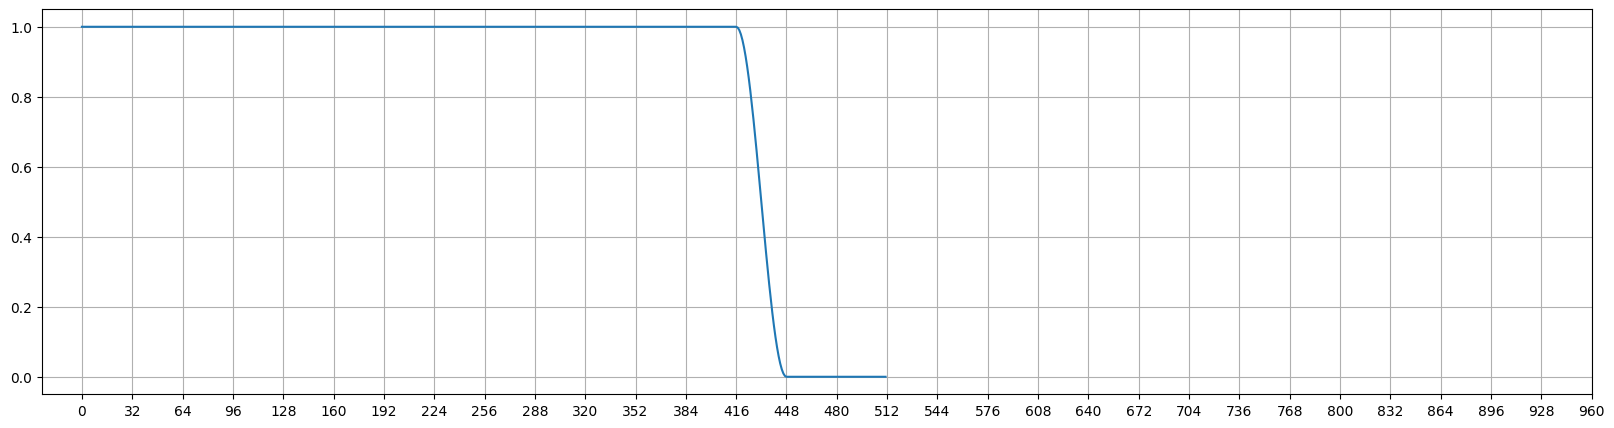

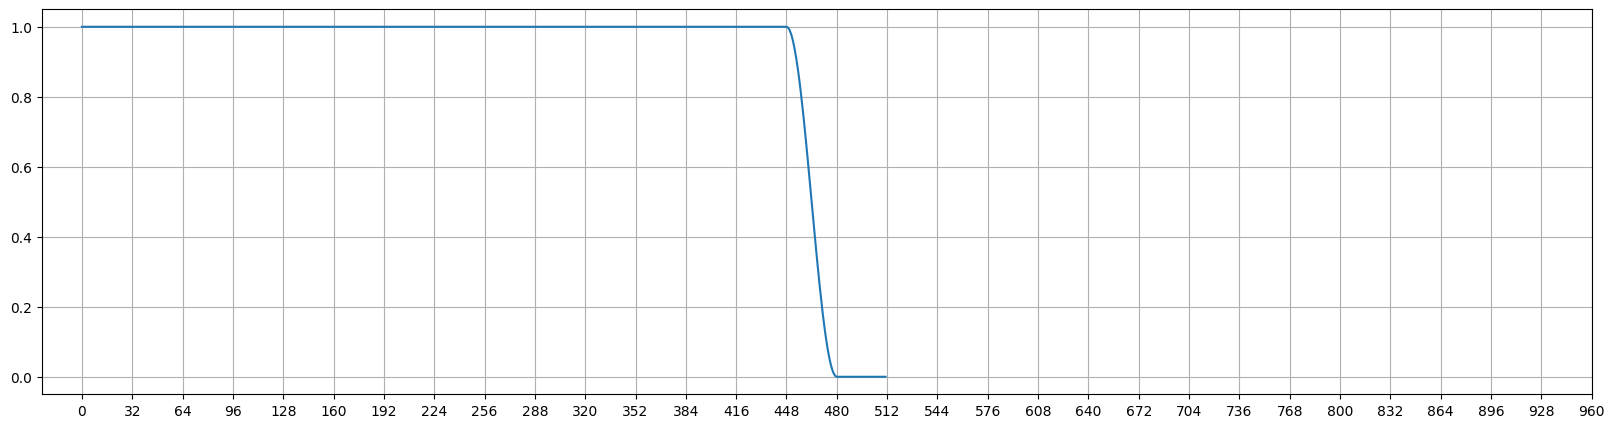

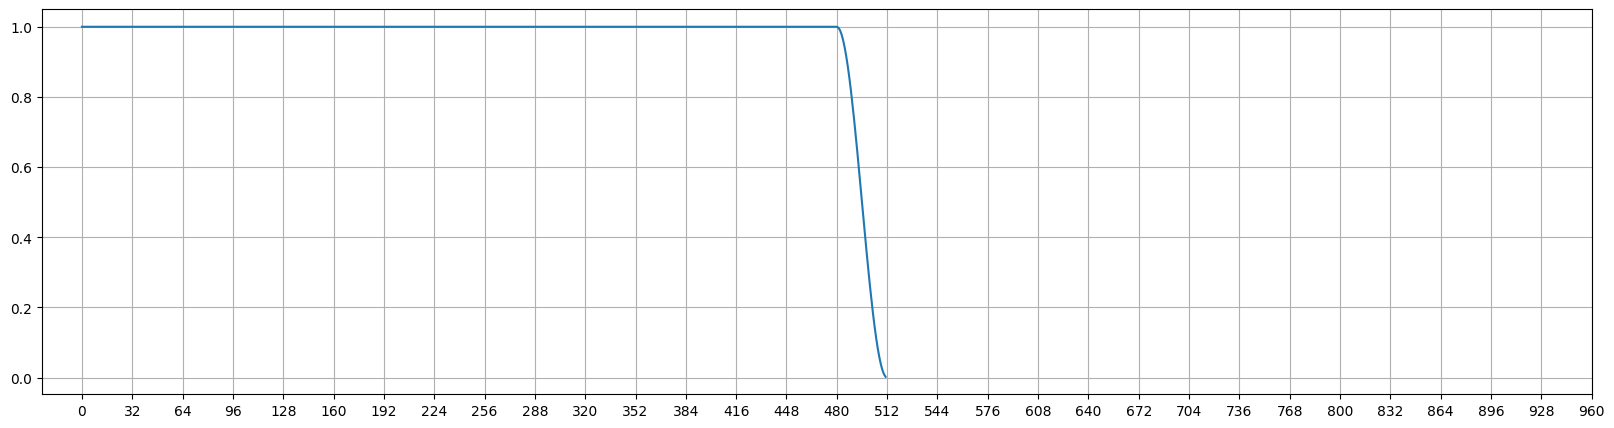

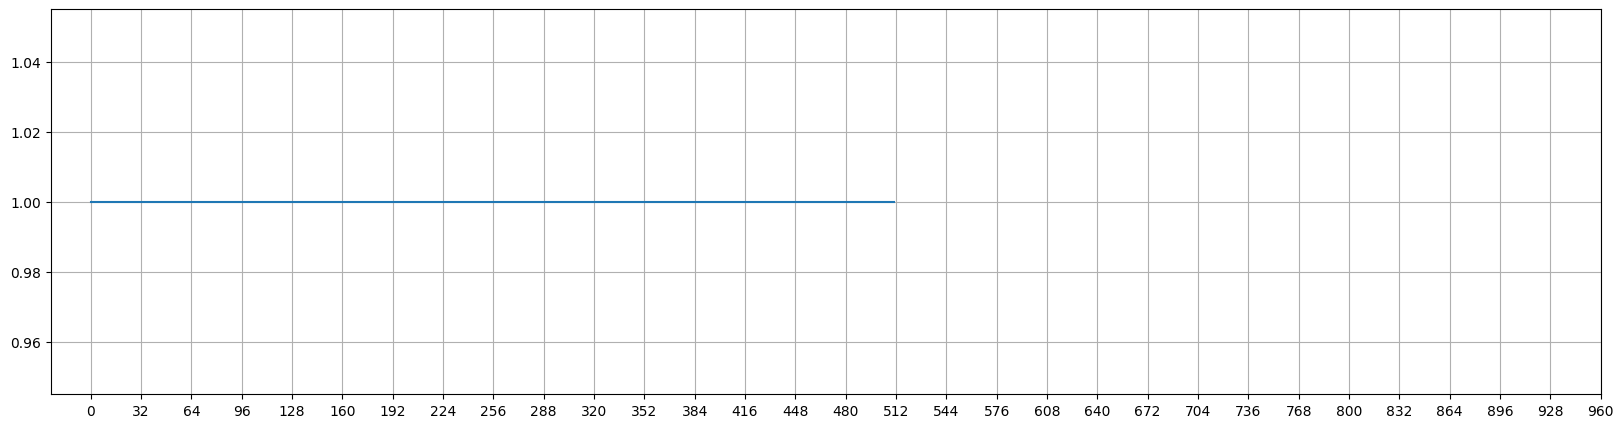

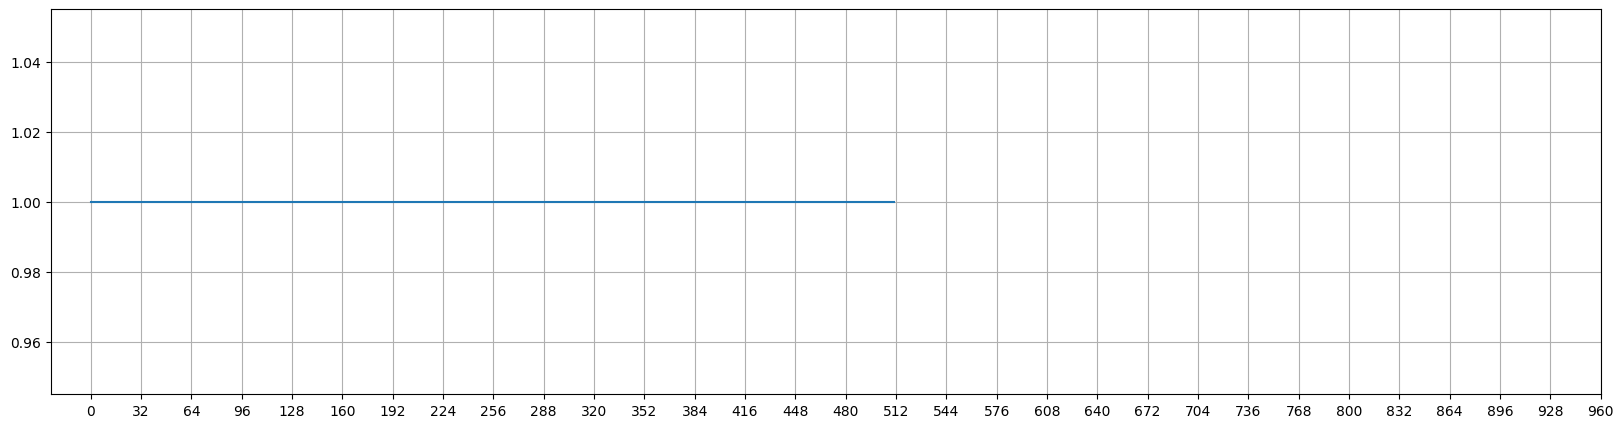

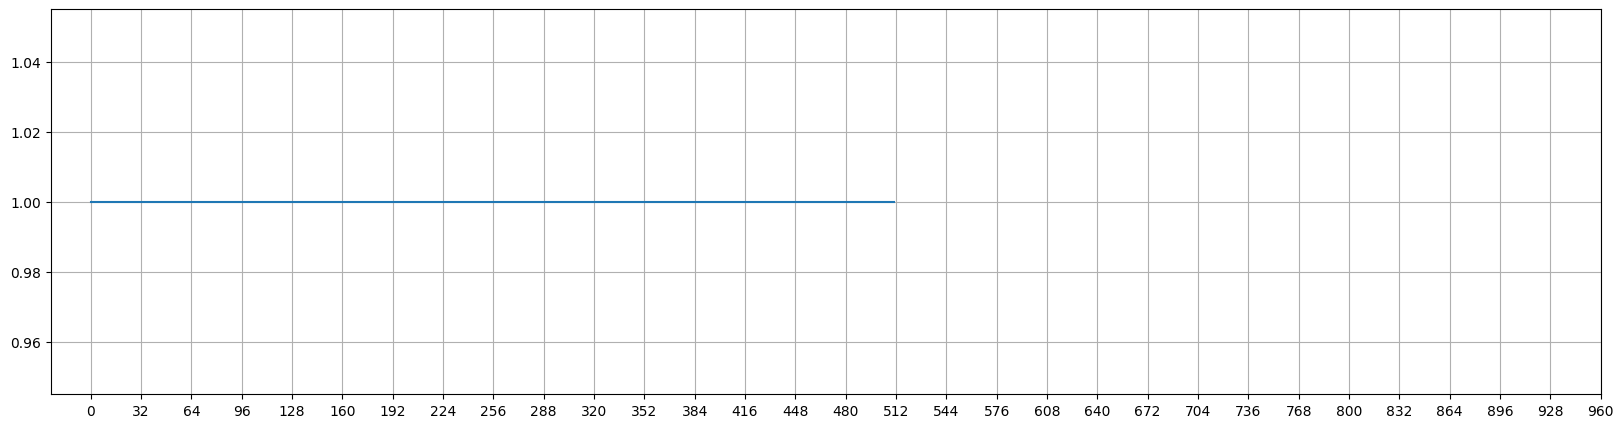

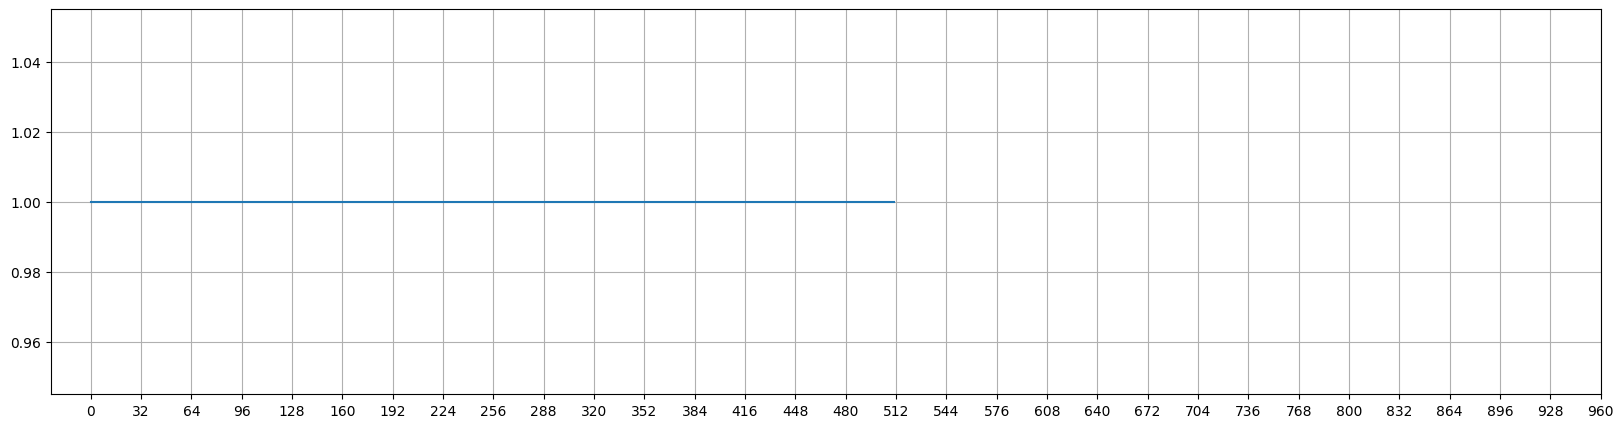

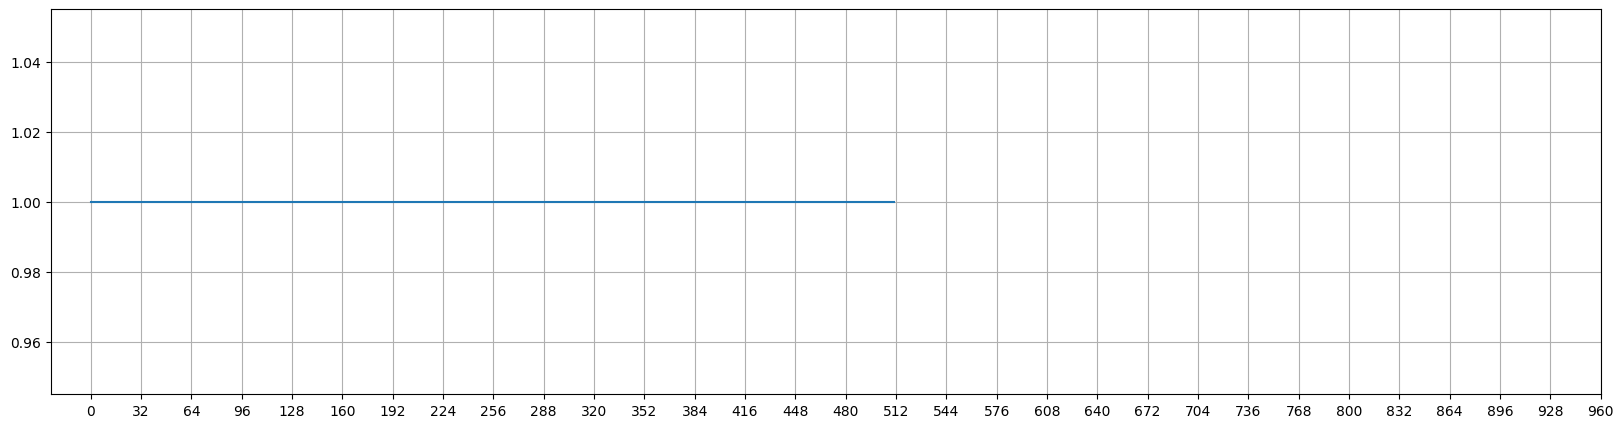

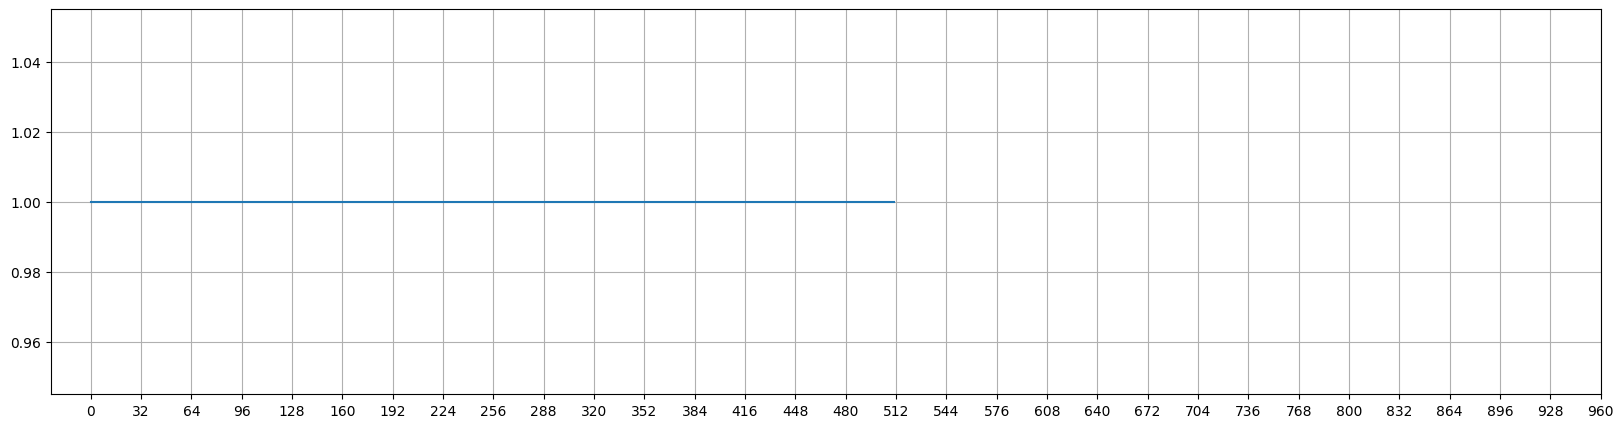

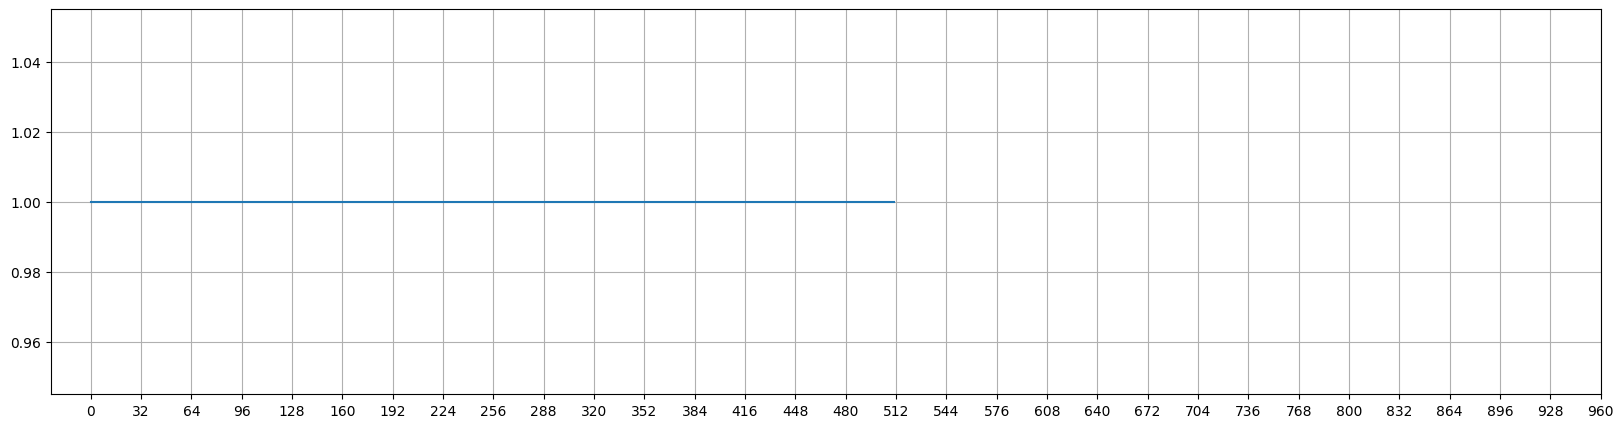

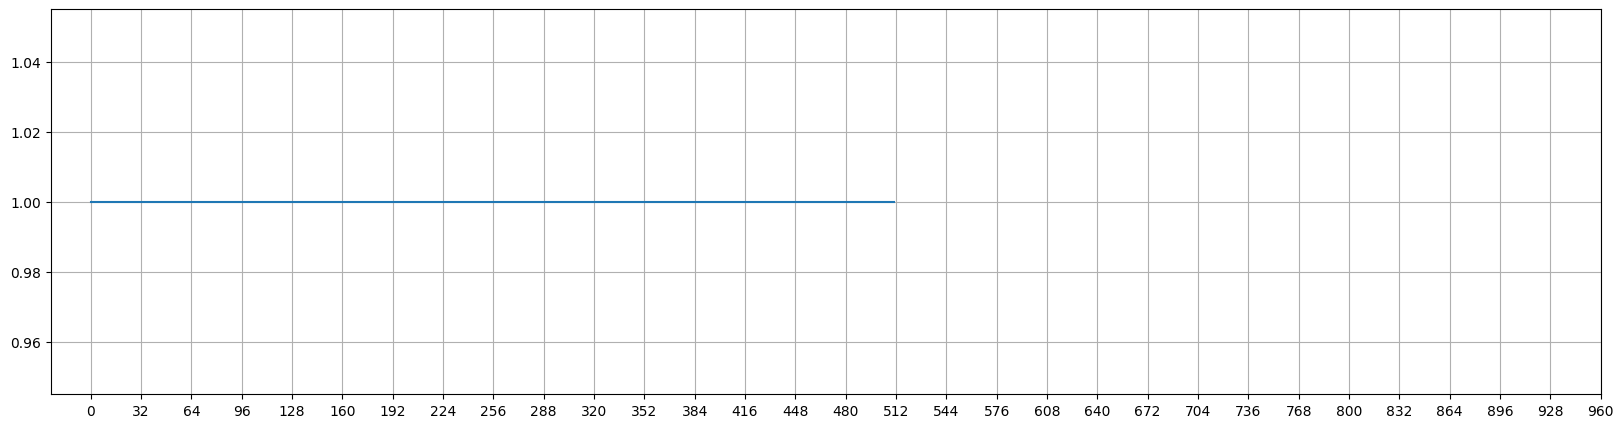

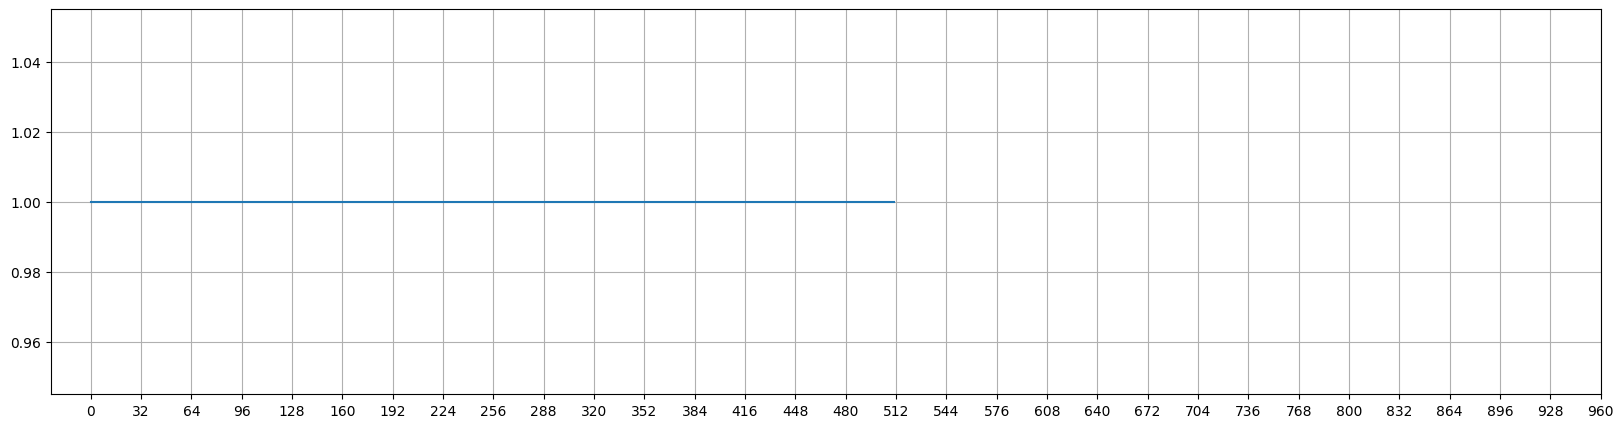

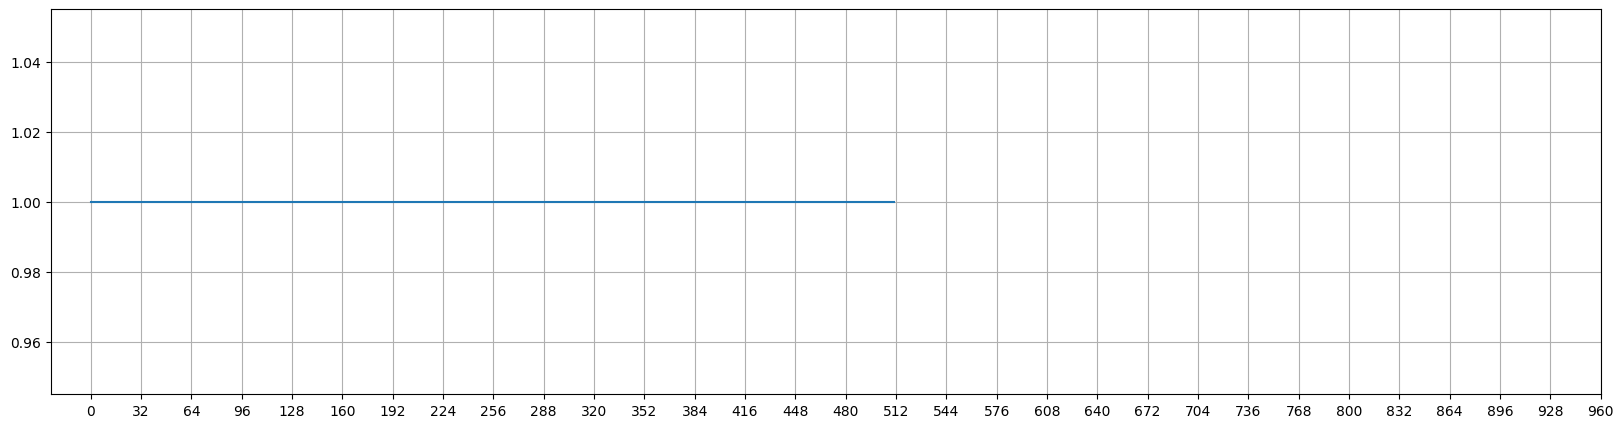

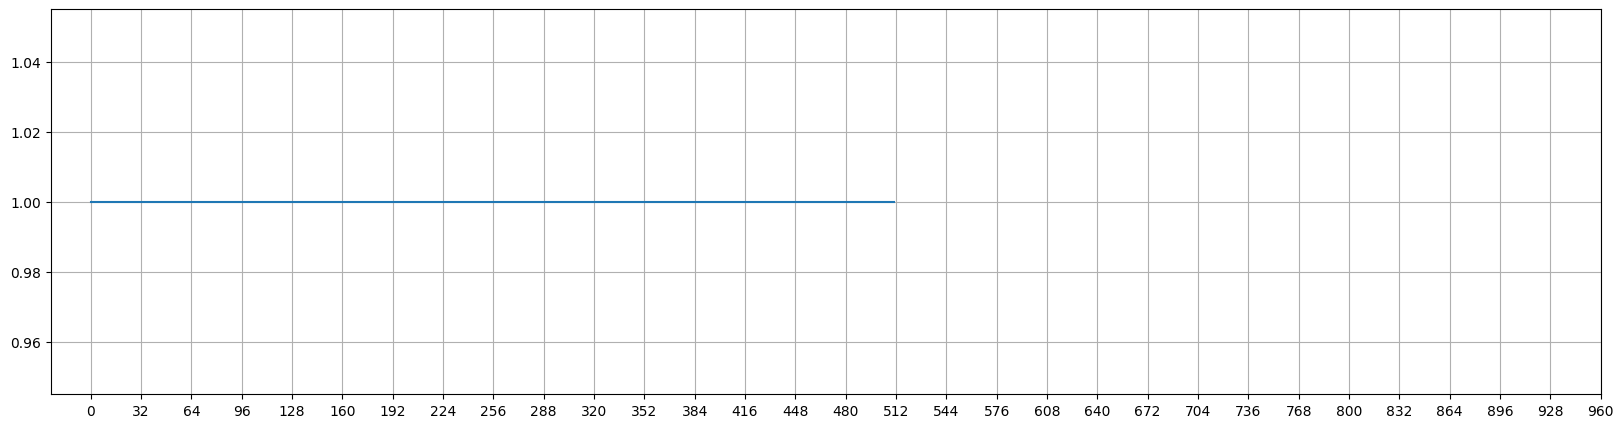

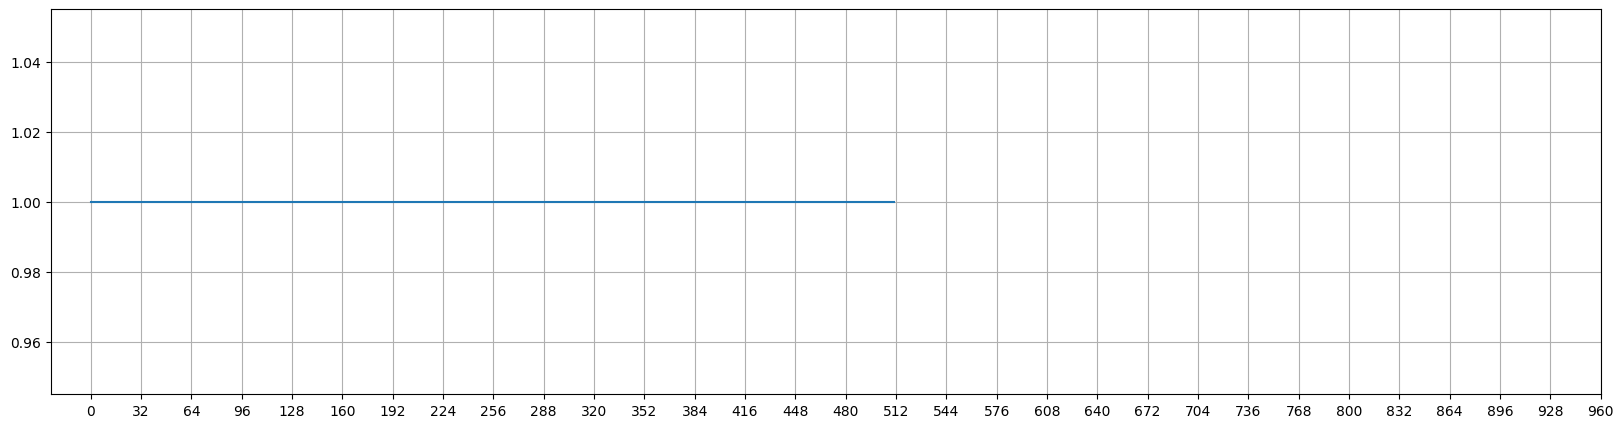

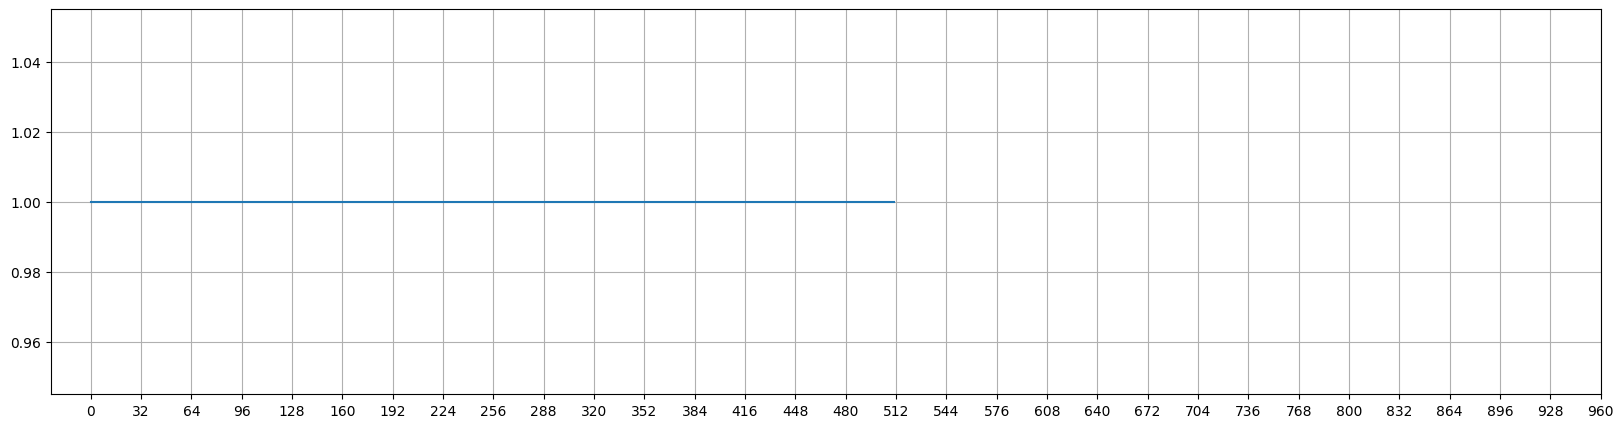

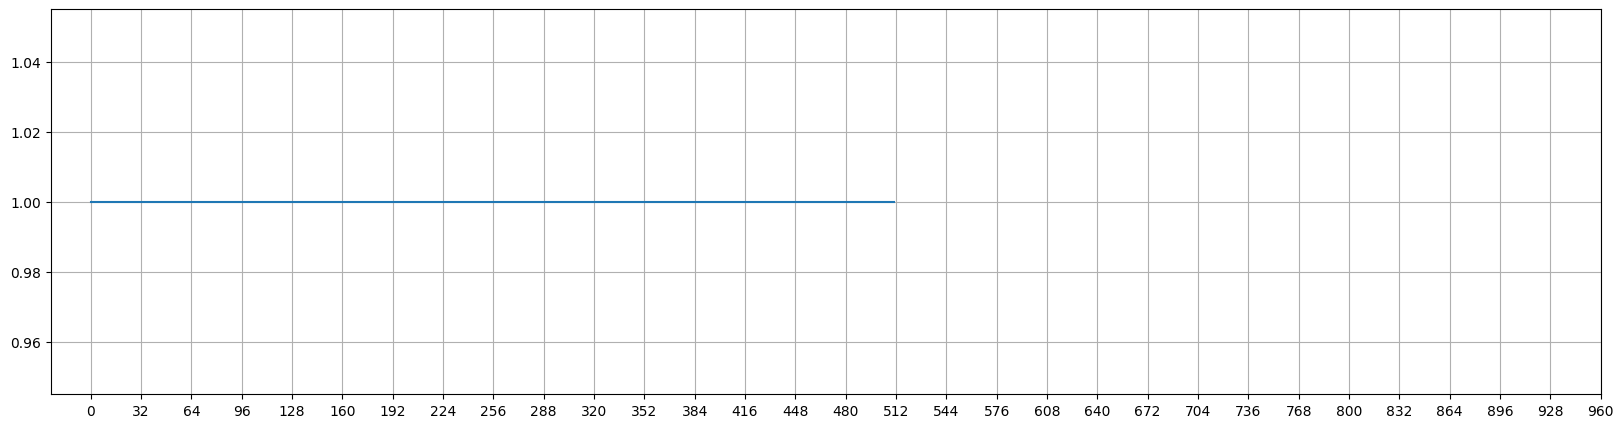

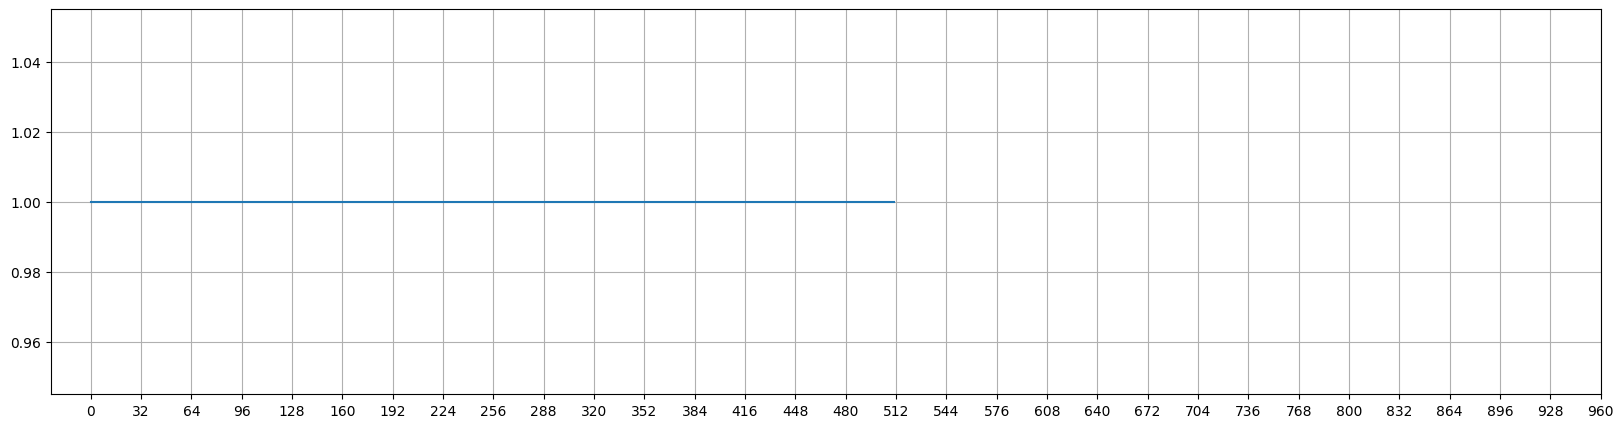

wav_sys.shape (512,)
512


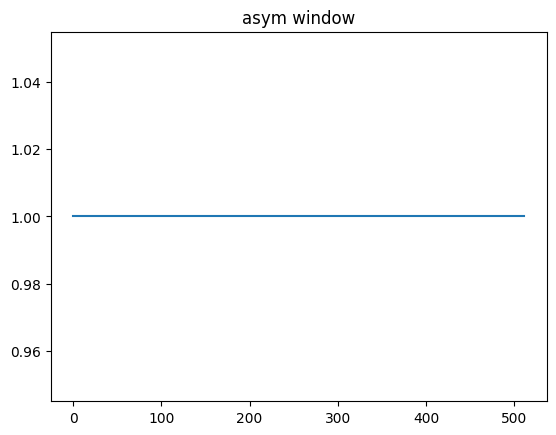

In [18]:
wav_sys = overlap_add(win_array, sys_hop_size=frame_len)
print(len(wav_sys))

plt.title('asym window')
plt.plot(wav_sys)
plt.show()